## Exercise 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

np.random.seed(123)


tau = pd.read_csv('coal-mine.csv', header = None).to_numpy().flatten()
tau = np.sort(tau)
t1 =  1851
tlast =  1963

In [35]:
def log_posterior(t, lamb, tau):    
    log_post = 0.0
    for j in range(len(lamb)):
        n_j = np.sum((tau >= t[j]) & (tau < t[j+1])) # use this instead of np.searchsorted, avoids error
        log_post += n_j * np.log(lamb[j]) - lamb[j] * (t[j+1] - t[j])
    return log_post

In [3]:
def hybridMCMC(d,v,rho):   
    # fixed v and sample initial theta
    theta = np.random.gamma(2, 1/v)

    # fixed d and sample initial t's
    t = np.sort(np.random.uniform(t1, tlast, d)) # initial t's uniformly distributed between [t1, tlast]
    t = np.concatenate( (np.array([t1]), t, np.array([tlast])))

    N = 10000
    probabs = []
    lamb_store = []
    theta_store = []
    t_store = []

    for i in range(N):
        # sample lambda
        ## use np.searchsorted to find n_i(tau) = number of disasters in [t_i, t_i+1)
        idx = np.searchsorted(tau, t)
        n = np.diff(idx)
        ## we need to sample each element lambda_i separately (where i = 1, ..., d)
        lamb = []
        for j in range(d):
            lamb.append(np.random.gamma(n[j]+2, 1/(theta + (t[j+1]-t[j]))))
        lamb = np.array(lamb)
        #store the lamb values
        lamb_store.append(lamb)
        
        # sample theta
        theta = np.random.gamma(2*d+2, 1/(v + np.sum(lamb)))
        theta_store.append(theta)
        
        # MH step for t
        ## choose candidate
        t_star = t.copy()
        for j in range(1, d+1):
            R = rho*(t[j+1] - t[j-1])
            eps = np.random.uniform(-R, R) # different epsilon for every t_i ??
            if t_star[j-1] < t[j] + eps < t_star[j+1]:
                t_star[j] = t[j] + eps

        ## accept or reject        
        acceptance_probab = min(0, log_posterior(t_star, lamb, tau)-log_posterior(t, lamb, tau))
        probabs.append(np.exp(acceptance_probab))
        u = np.log(np.random.uniform())
        if u <= acceptance_probab:
            # accept candidate
            t = t_star
            # else t stays the same
        t_store.append(t)
    return(lamb_store,theta_store,t_store,probabs)

### 1c)

Sensitivity when changing d={1,2,3,4}:

In [4]:
values_d=[]
for d in range(1,5):
    val = hybridMCMC(d,v=2,rho = 0.5)
    values_d.append(val) 

#### acceptance probabs

In [5]:
for d in range(4):
    print(f'd-1={d-1} breakpoints: mean acceptance probab {"%.4f" % np.average(values_d[d][3])}')

d-1=-1 breakpoints: mean acceptance probab 0.2440
d-1=0 breakpoints: mean acceptance probab 0.3120
d-1=1 breakpoints: mean acceptance probab 0.2602
d-1=2 breakpoints: mean acceptance probab 0.2180


#### trace plot theta

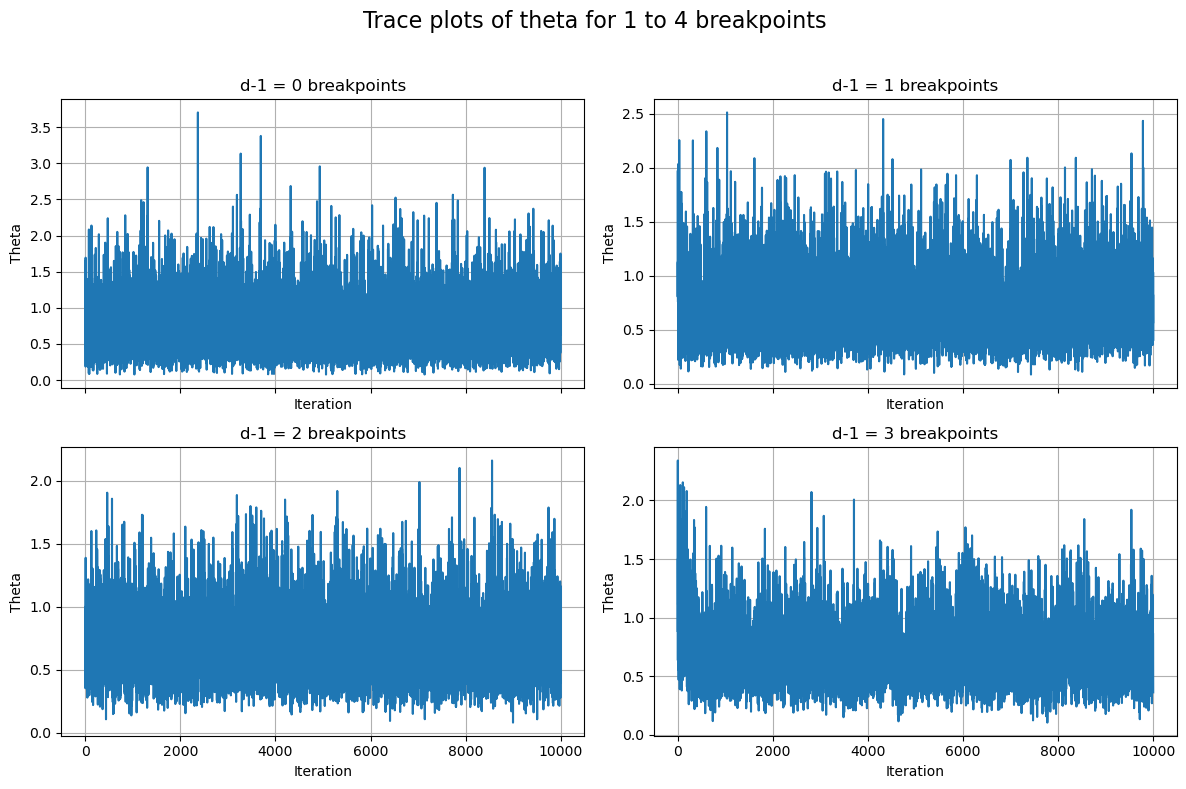

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten() 

for d in range(4):
    theta_store = values_d[d][1]
    ax = axes[d]
    ax.plot(theta_store)
    ax.set_title(f"d-1 = {d} breakpoints")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for 1 to 4 breakpoints", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### trace plot lambda

In [7]:
# #for d=4 all the lambdas for all the breakpoints different
# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
# axes = axes.flatten()

# for d in range(4):
#     lamb_store = np.array(values_d[d][0])
#     ax = axes[d]
#     ax.plot(lamb_store)
#     #ax.plot(lamb_store[:,d])
#     ax.set_title(f"d = {d+1}")
#     ax.set_xlabel("Iteration")
#     ax.set_ylabel("Lambda")
#     ax.grid(True)

# #i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
# fig.suptitle("Trace plots of lambda_d for d = {1,2,3,4}", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 
# plt.show()

In [8]:
# # trying to just plot all d=4, all lambda
# #so plotting all the breakpoints for d=4 
# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
# axes = axes.flatten()

# for d in range(4):
#     lamb_store = np.array(values_d[3][0])
#     ax = axes[d]
#     ax.plot(lamb_store[:,d])
#     #ax.plot(lamb_store[:,d])
#     ax.set_title(f"d = {d+1}")
#     ax.set_xlabel("Iteration")
#     ax.set_ylabel("Lambda")
#     ax.grid(True)

# #i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
# fig.suptitle("Trace plots of lambda_4 for d = {1,2,3,4}", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 
# plt.show()

In [9]:
# #now plotting always the lamda_d for d
# #so for d=3 the third lambda, for d=2 the second lambda
# #so just plotting the d-th lambda for d={1,2,3,4}
# fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
# axes = axes.flatten()

# for d in range(4):
#     lamb_store = np.array(values_d[d][0])
#     ax = axes[d]
#     ax.plot(lamb_store[:,0])
#     ax.set_title(f"d = {d+1}")
#     ax.set_xlabel("Iteration")
#     ax.set_ylabel("Lambda")
#     ax.grid(True)

# #i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
# fig.suptitle("Trace plots of lambda_d for d = {1,2,3,4}", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96]) 
# plt.show()

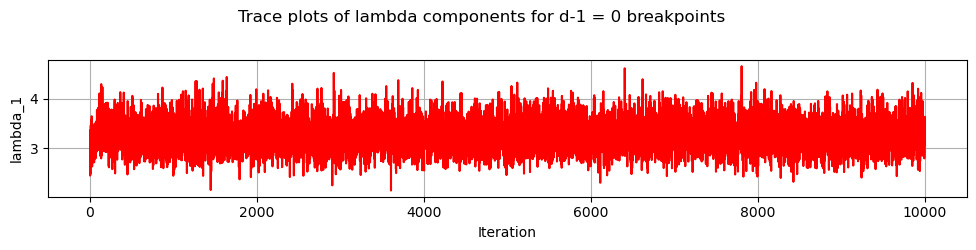

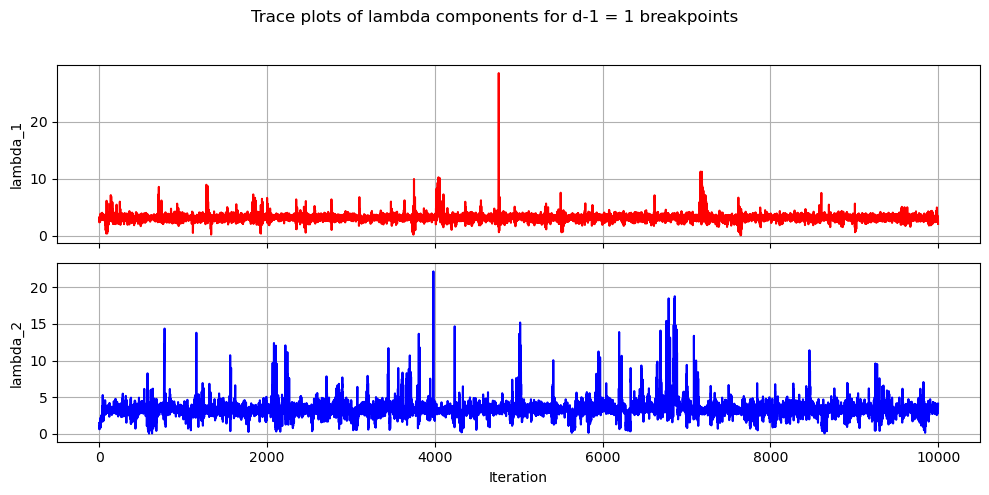

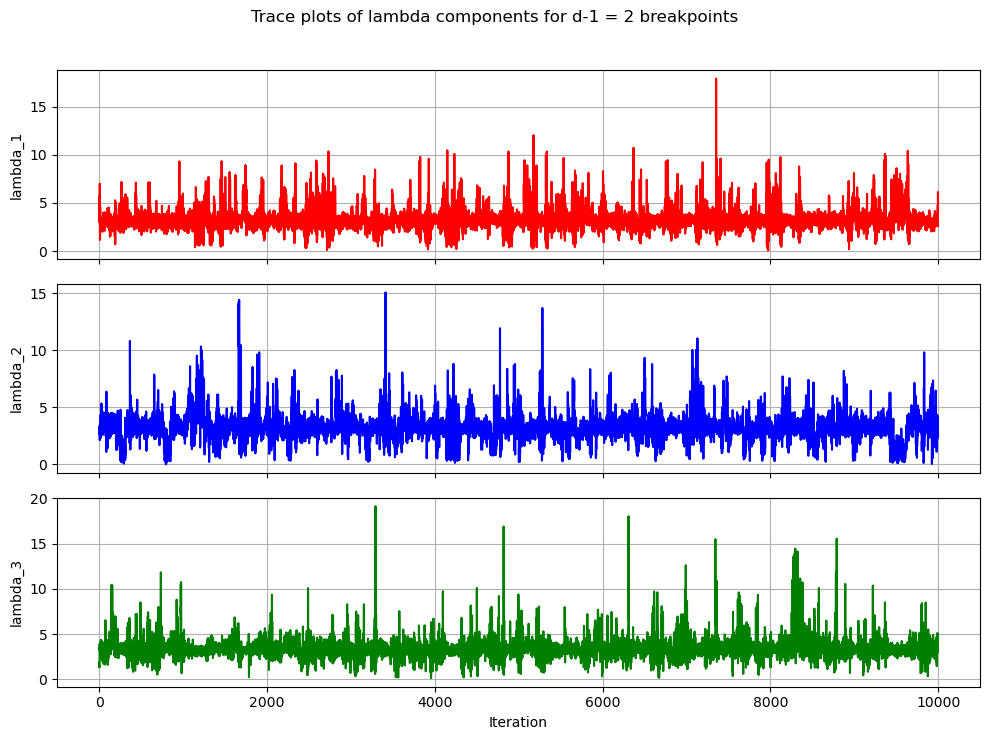

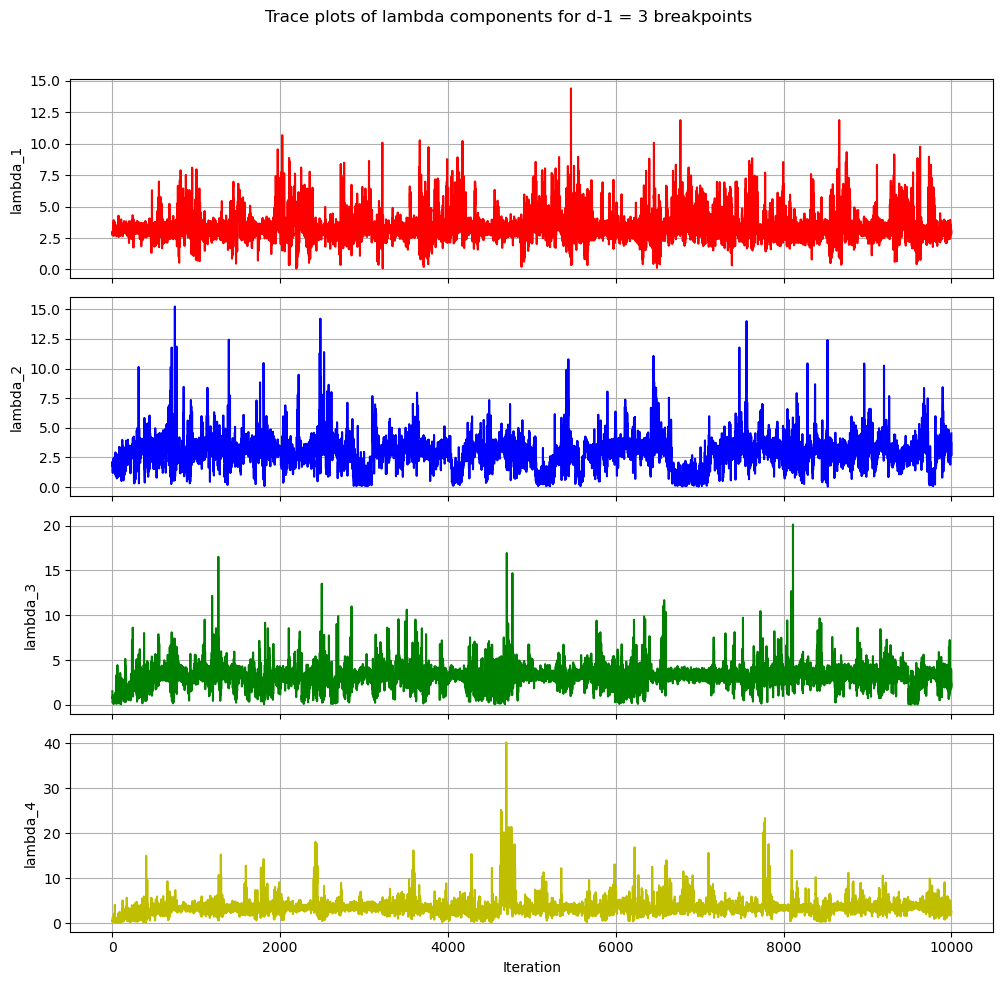

In [10]:
# try to use subplots instead
colors = ['r', 'b', 'g', 'y']

for d in range(4):
    lamb_store = np.array(values_d[d][0])

    # new figure for every d
    fig, axes = plt.subplots(d+1, 1, figsize=(10, 2.5*(d+1)), sharex=True)
    if d == 0:
        axes = [axes] # otherwise you can't index later

    # d subplots for every value of d
    for i in range(d+1):
        ax = axes[i]
        ax.plot(lamb_store[:,i], color = colors[i])
        ax.set_ylabel(f"lambda_{i+1}")
        ax.grid(True)
        
    axes[-1].set_xlabel("Iteration")
    fig.suptitle(f"Trace plots of lambda components for d-1 = {d} breakpoints")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

#### trace plot t

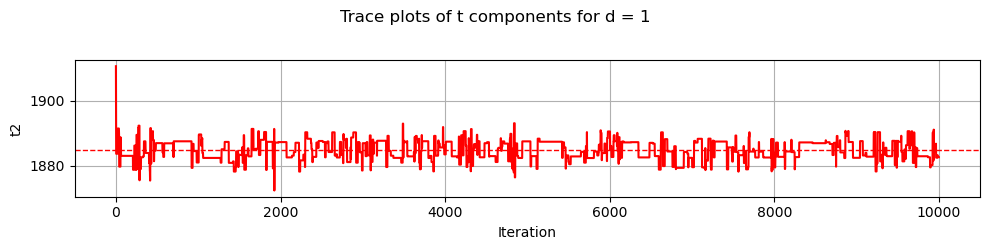

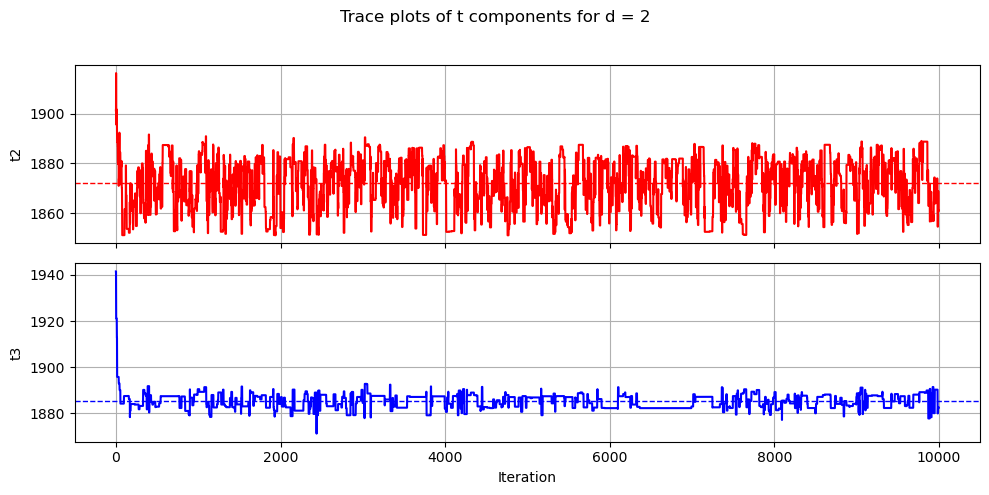

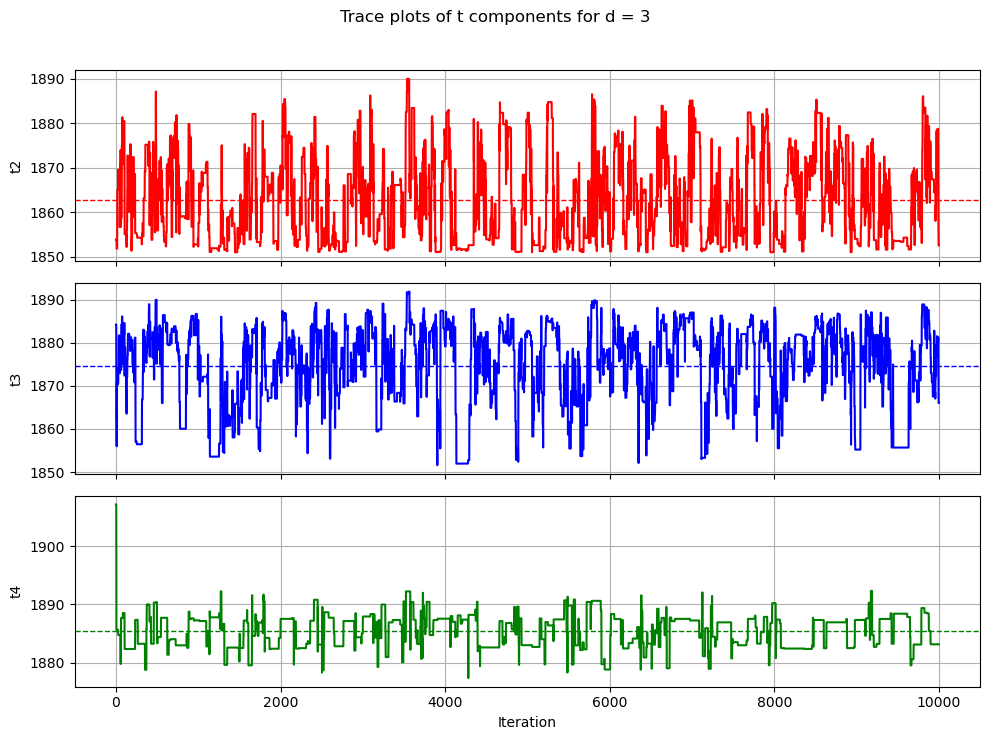

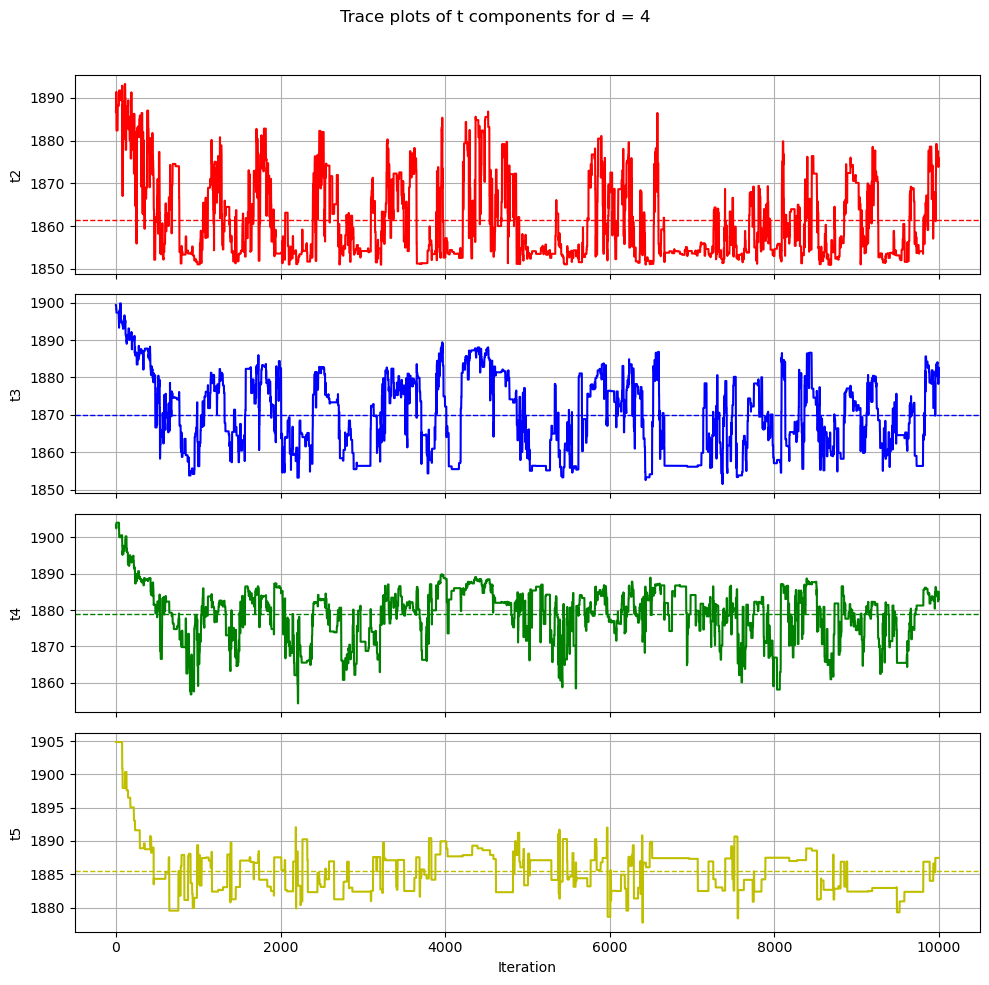

In [34]:
colors = ['r', 'b', 'g', 'y']

for d in range(4):
    t_store = np.array(values_d[d][2])

    fig, axes = plt.subplots(d+1, 1, figsize=(10, 2.5*(d+1)), sharex=True)

    if d == 0:
        axes = [axes]

    for i in range(d+1):
        ax = axes[i]
        t_idx = i + 1
        ax.plot(t_store[:, t_idx], color = colors[i])

        mean_val = np.mean(t_store[:, t_idx])
        ax.axhline(mean_val, color=colors[i], linestyle='--', linewidth=1, label='Mean')

        ax.set_ylabel(f"t{t_idx+1}")
        ax.grid(True)
        
    axes[-1].set_xlabel("Iteration")
    fig.suptitle(f"Trace plots of t components for d = {d+1}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

#### other things - posterior, autocorr

In [12]:
# #density of posterior after burn-in
# plt.figure(figsize=(10, 6))
# for d in range(4):
#     theta_chain = values_d[d][1][1000:]  #after burn-in
#     sns.kdeplot(theta_chain, label=f'd={d+1}',fill=False)
# plt.title("Posterior Density of Theta for different d")
# plt.xlabel("Theta")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

In [13]:
# #density of posterior after burn-in
# plt.figure(figsize=(10, 6))
# for d in range(4):
#     lambda_chain = np.array(values_d[d][0])[1000:]  #after burn-in
#     sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
# plt.title("Posterior Density of Lambda for different d")
# plt.xlabel("Lambda")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

In [14]:
# #density of posterior after burn-in
# plt.figure(figsize=(10, 6))
# for d in [0]:# range(4):
#     lambda_chain = np.array(values_d[d][2])[1000:]  #after burn-in
#     sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
# plt.title("Posterior Density of Lambda for different d")
# plt.xlabel("Lambda")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

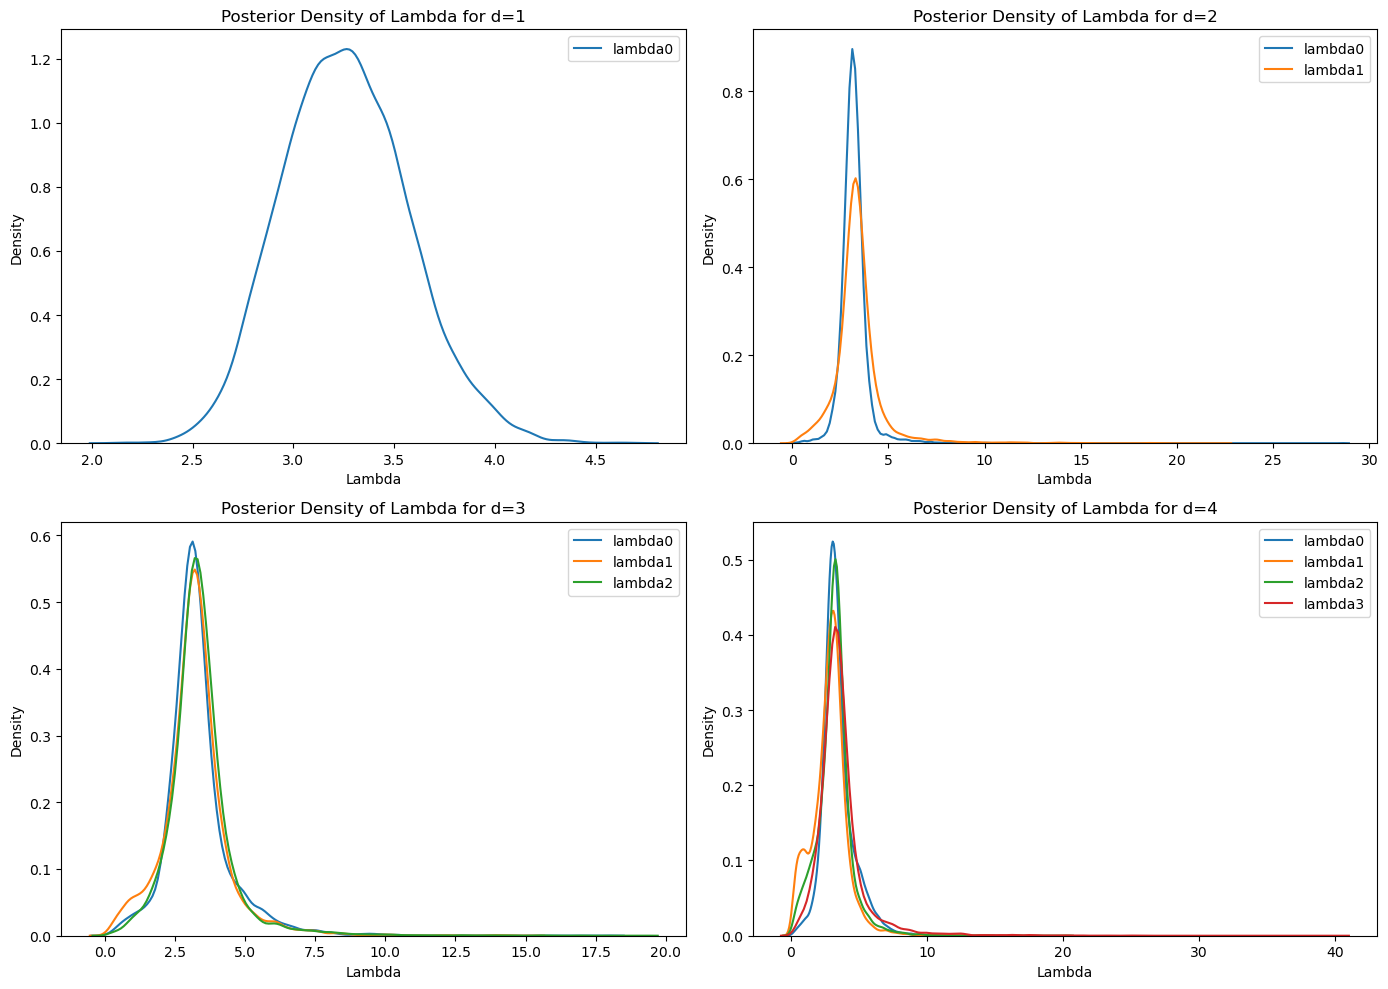

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

for d in range(4):
    ax = axes[d]
    lambda_chain = np.array(values_d[d][0])[1000:] # after burn-in
    for i in range(lambda_chain.shape[1]):
        sns.kdeplot(lambda_chain[:, i], label=f"lambda{i}", fill=False, ax=ax, warn_singular=False)
    ax.set_title(f"Posterior Density of Lambda for d={d+1}")
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

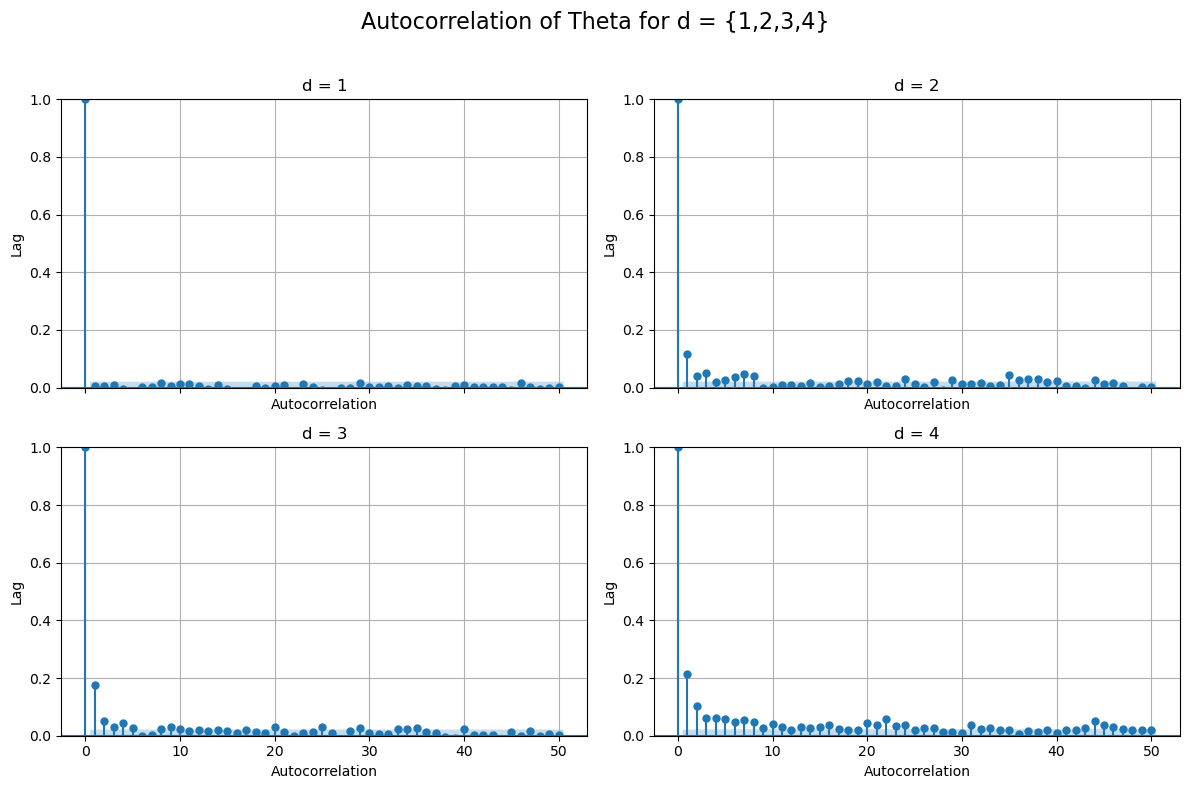

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for d in range(4):
    theta_store = np.array(values_d[d][1])
    ax = axes[d]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"d = {d+1}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for d = {1,2,3,4}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### 1d)

Sensitivity for different v:

In [17]:
values_v=[]
v_vec = [0.5, 1, 2, 3]
for diff_v in v_vec:
     val = hybridMCMC(d=2, v=diff_v, rho = 0.5)
     values_v.append(val)

#### acceptance probabs

In [18]:
for v in range(4):
    print(f'v={v_vec[v]}: mean acceptance probab {"%.4f" % np.average(values_v[v][3])}')

v=0.5: mean acceptance probab 0.3102
v=1: mean acceptance probab 0.3123
v=2: mean acceptance probab 0.2990
v=3: mean acceptance probab 0.3019


#### posterior of theta

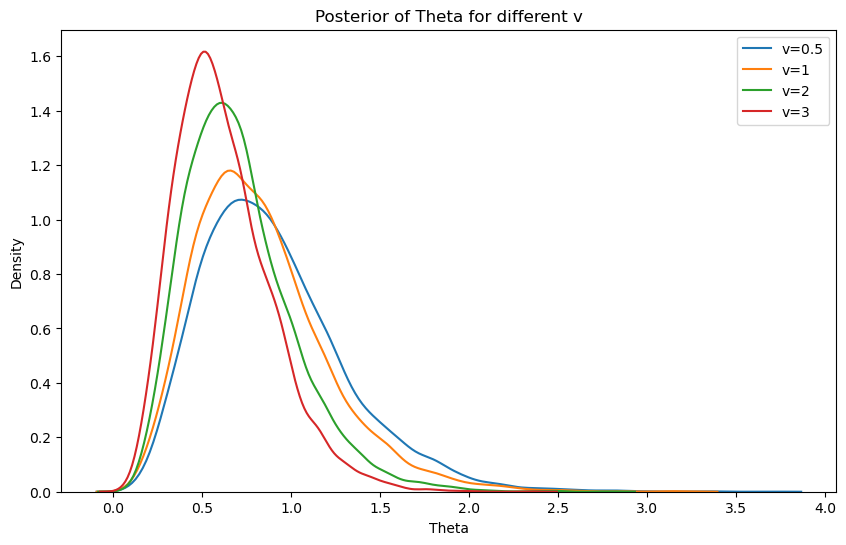

In [19]:
plt.figure(figsize=(10, 6))
for v in range(4):
    theta_chain = values_v[v][1][1000:]  #after burn-in
    sns.kdeplot(theta_chain, label=f'v={v_vec[v]}',fill=False)
plt.title("Posterior of Theta for different v")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

#### posterior of lambda

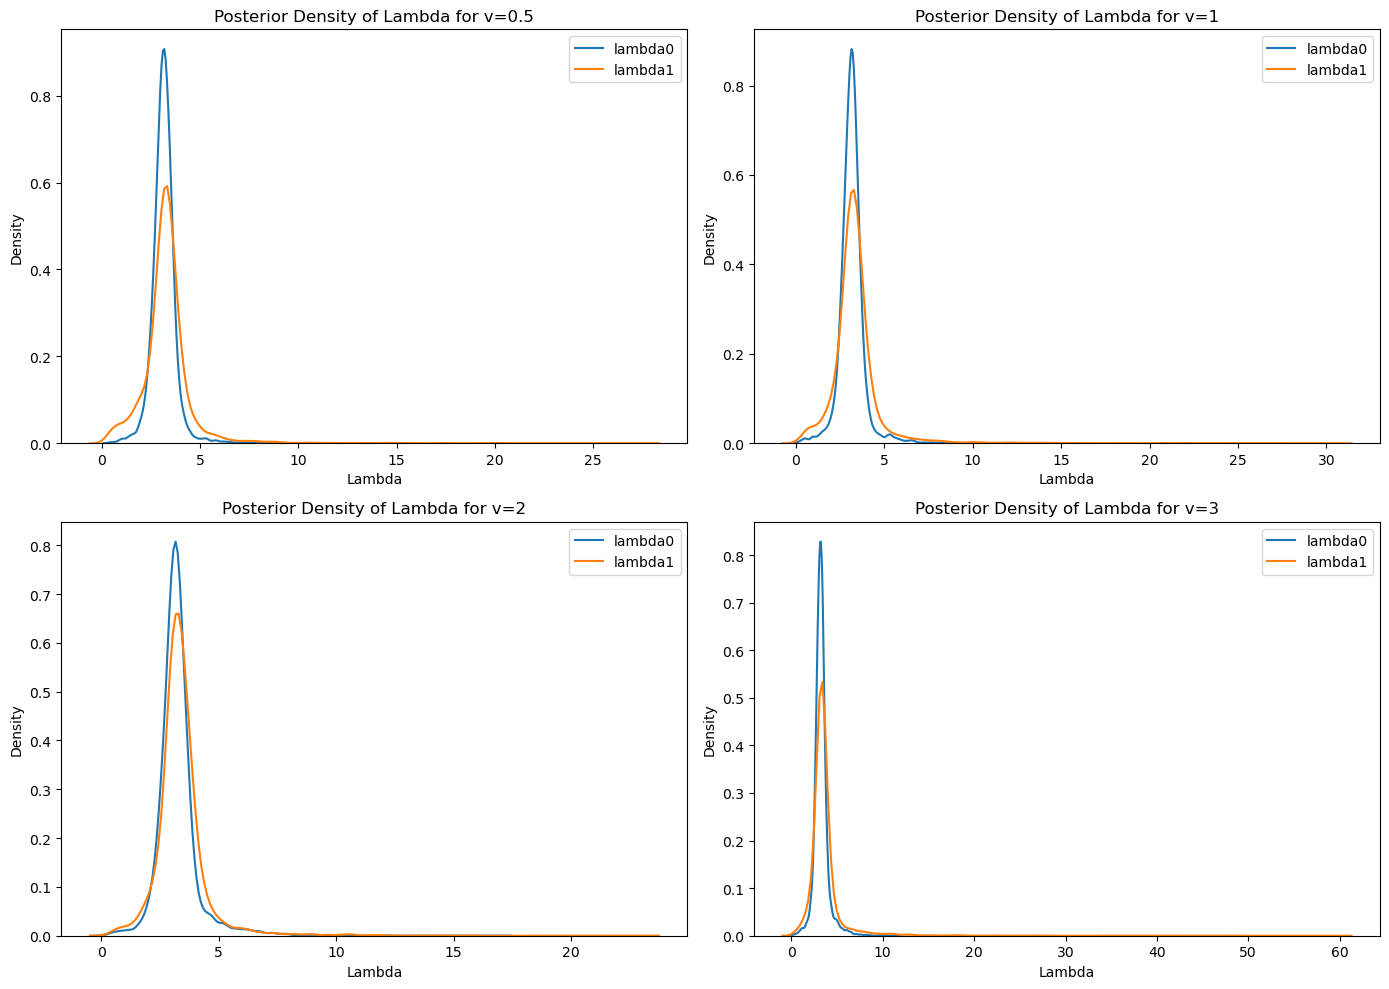

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

for v in range(4):
    ax = axes[v]
    lambda_chain = np.array(values_v[v][0])[1000:] # after burn-in
    for i in range(lambda_chain.shape[1]):
        sns.kdeplot(lambda_chain[:, i], label=f"lambda{i}", fill=False, ax=ax, warn_singular=False)
    ax.set_title(f"Posterior Density of Lambda for v={v_vec[v]}")
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

#### posterior of t

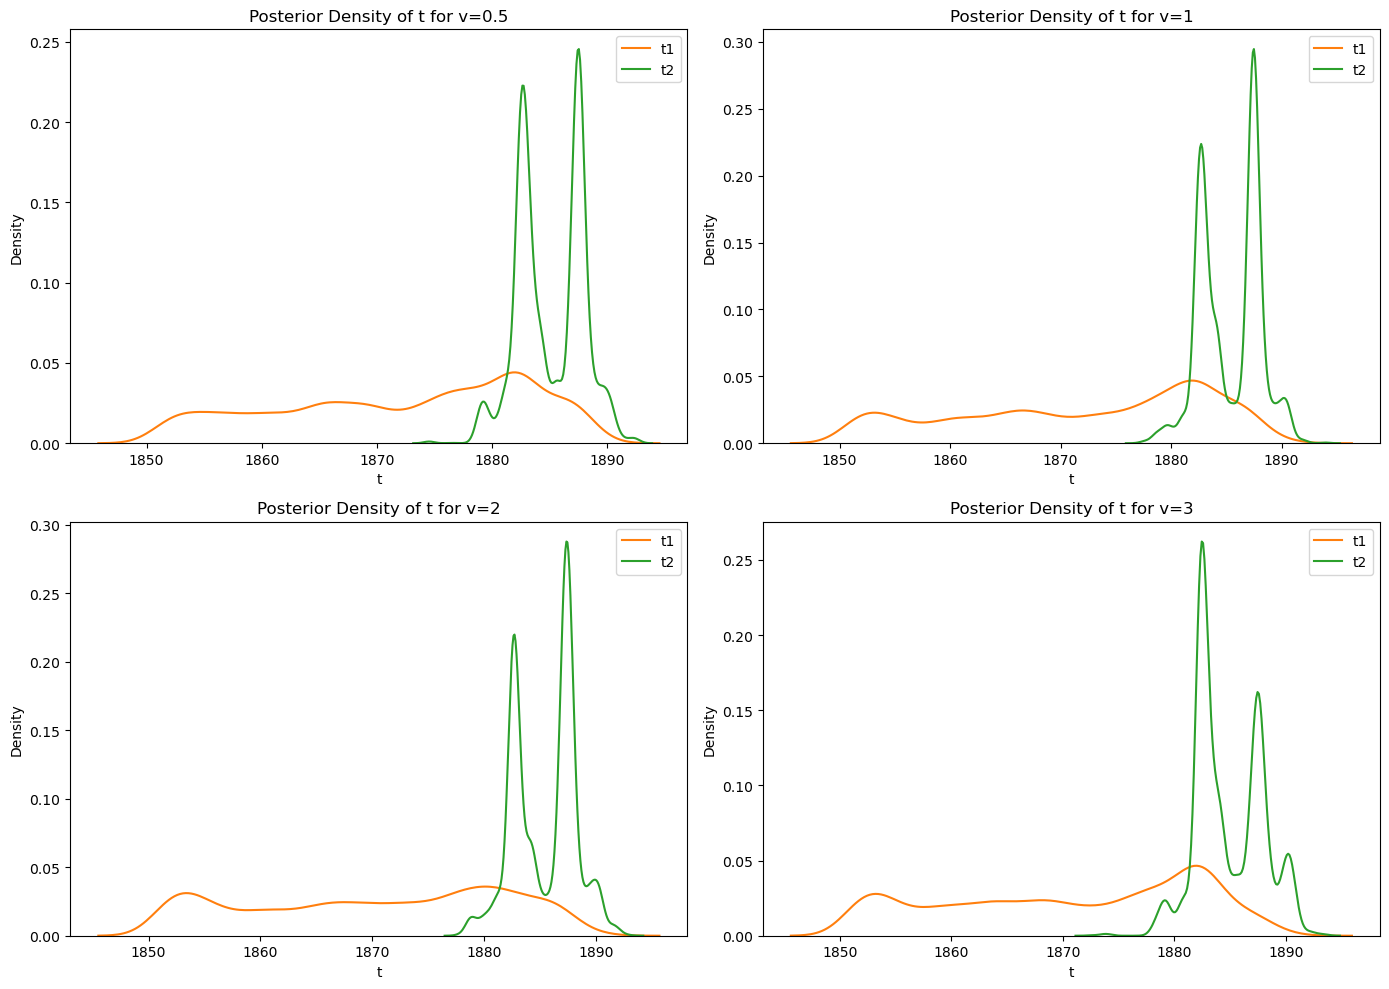

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

for v in range(4):
    ax = axes[v]
    t_chain = np.array(values_v[v][2])[1000:] # after burn-in
    for i in range(t_chain.shape[1]):
        sns.kdeplot(t_chain[:, i], label=f"t{i}", fill=False, ax=ax, warn_singular=False)
    ax.set_title(f"Posterior Density of t for v={v_vec[v]}")
    ax.set_xlabel("t")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

#### other things -- trace, autocorr

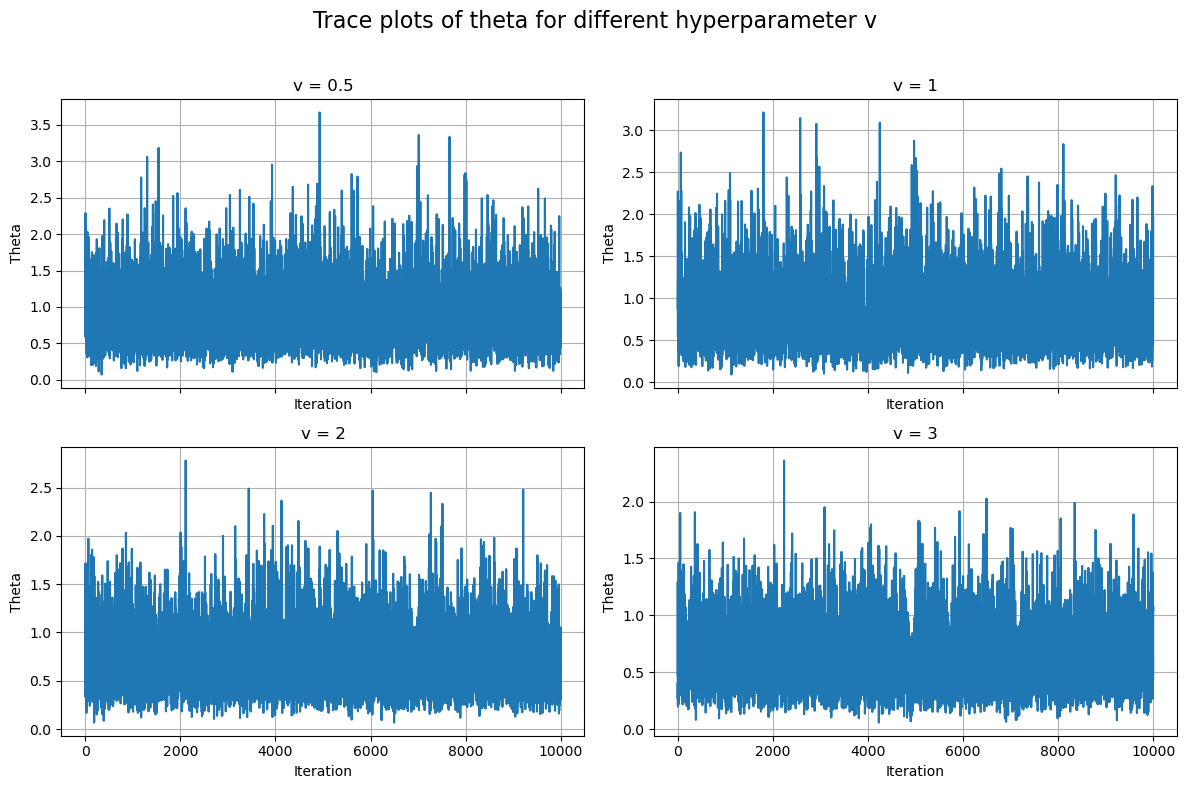

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
v_vec = [0.5, 1, 2, 3]

for v in range(4):
    theta_store = values_v[v][1]
    ax = axes[v]
    ax.plot(theta_store)
    ax.set_title(f"v = {v_vec[v]}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for different hyperparameter v", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

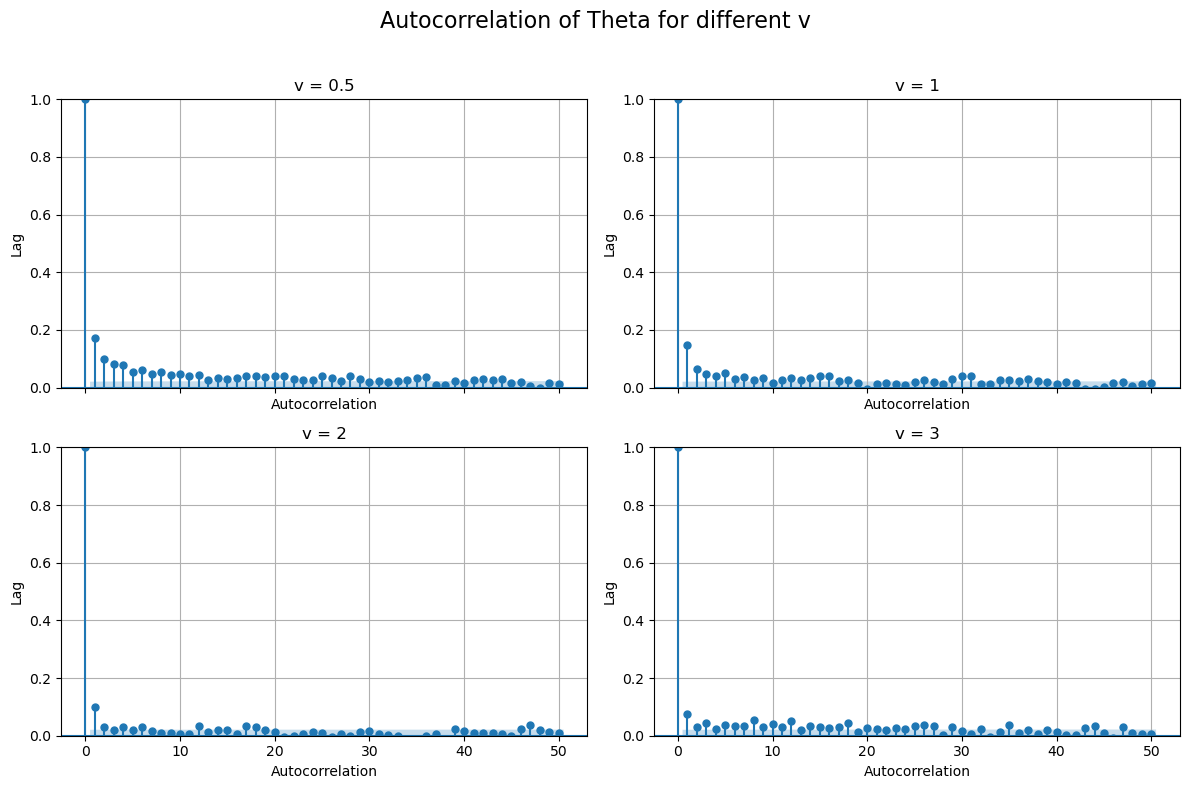

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for v in range(4):
    theta_store = np.array(values_v[v][1])
    ax = axes[v]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"v = {v_vec[v]}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for different v", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### 1e) different rho

In [24]:
values_rho=[]
rho_vec = [0.5, 1, 2, 3]
for diff_rho in rho_vec:
     val = hybridMCMC(d=2, v=2, rho = diff_rho)
     values_rho.append(val)

#### acceptance probabs

In [25]:
for rho in range(4):
    print(f'rho={rho_vec[rho]}: mean acceptance probab {"%.4f" % np.average(values_rho[rho][3])}')

rho=0.5: mean acceptance probab 0.3105
rho=1: mean acceptance probab 0.4006
rho=2: mean acceptance probab 0.6704
rho=3: mean acceptance probab 0.7822


#### traces

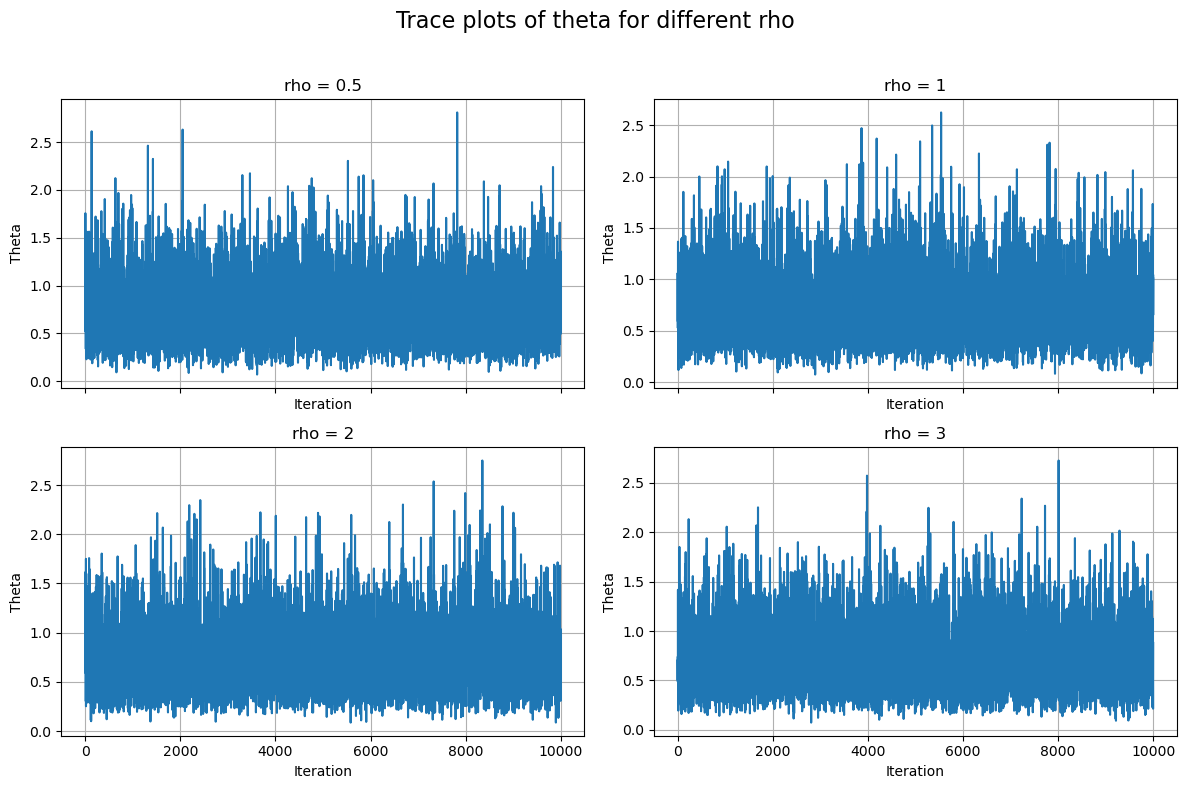

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for rho in range(4):
    theta_store = values_rho[rho][1]
    ax = axes[rho]
    ax.plot(theta_store)
    ax.set_title(f"rho = {rho_vec[rho]}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for different rho", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

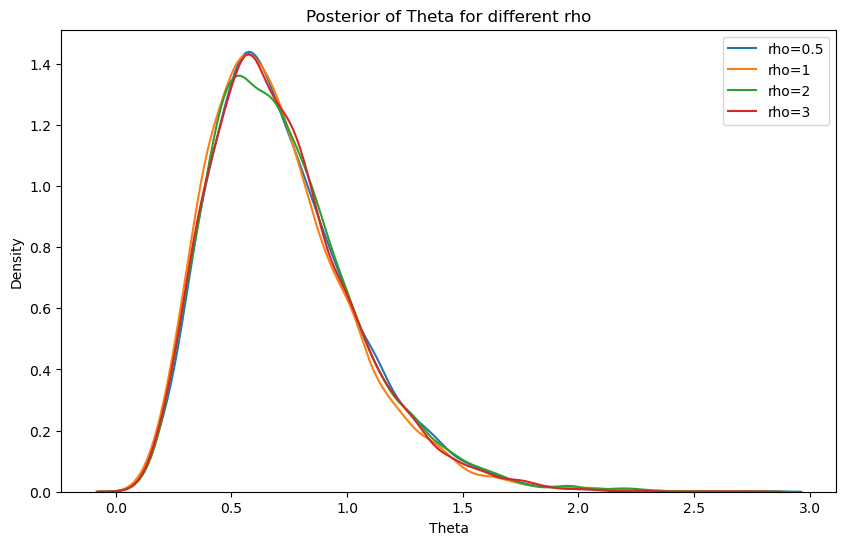

In [27]:
plt.figure(figsize=(10, 6))
for rho in range(4):
    theta_chain = values_rho[rho][1][1000:]  #after burn-in
    sns.kdeplot(theta_chain, label=f'rho={rho_vec[rho]}',fill=False)
plt.title("Posterior of Theta for different rho")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

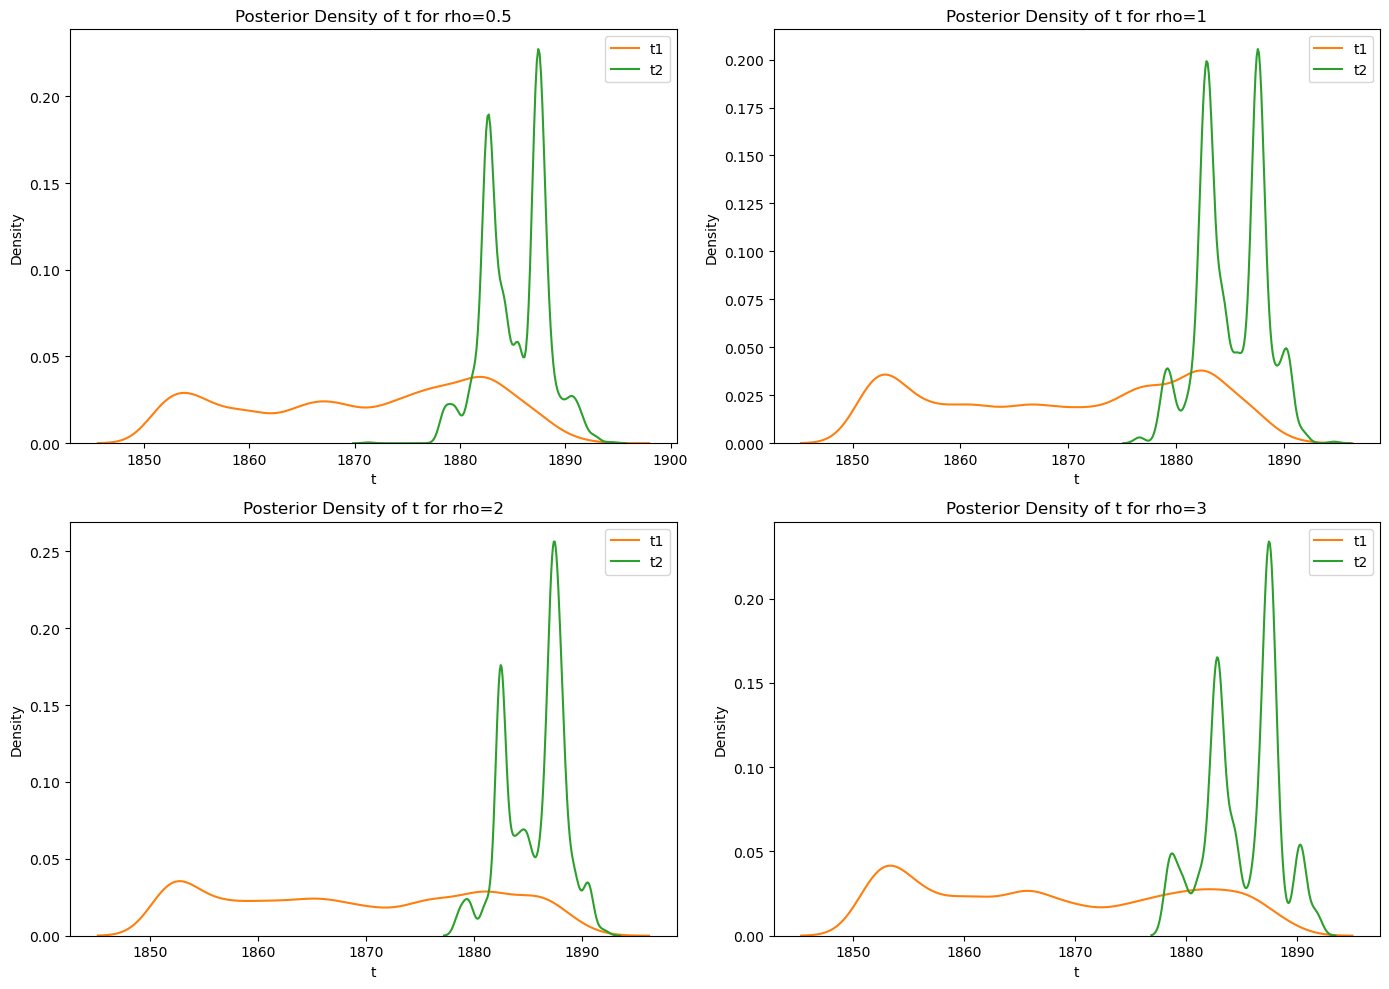

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

for rho in range(4):
    ax = axes[rho]
    t_chain = np.array(values_rho[rho][2])[1000:] # after burn-in
    for i in range(t_chain.shape[1]):
        sns.kdeplot(t_chain[:, i], label=f"t{i}", fill=False, ax=ax, warn_singular=False)
    ax.set_title(f"Posterior Density of t for rho={rho_vec[rho]}")
    ax.set_xlabel("t")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

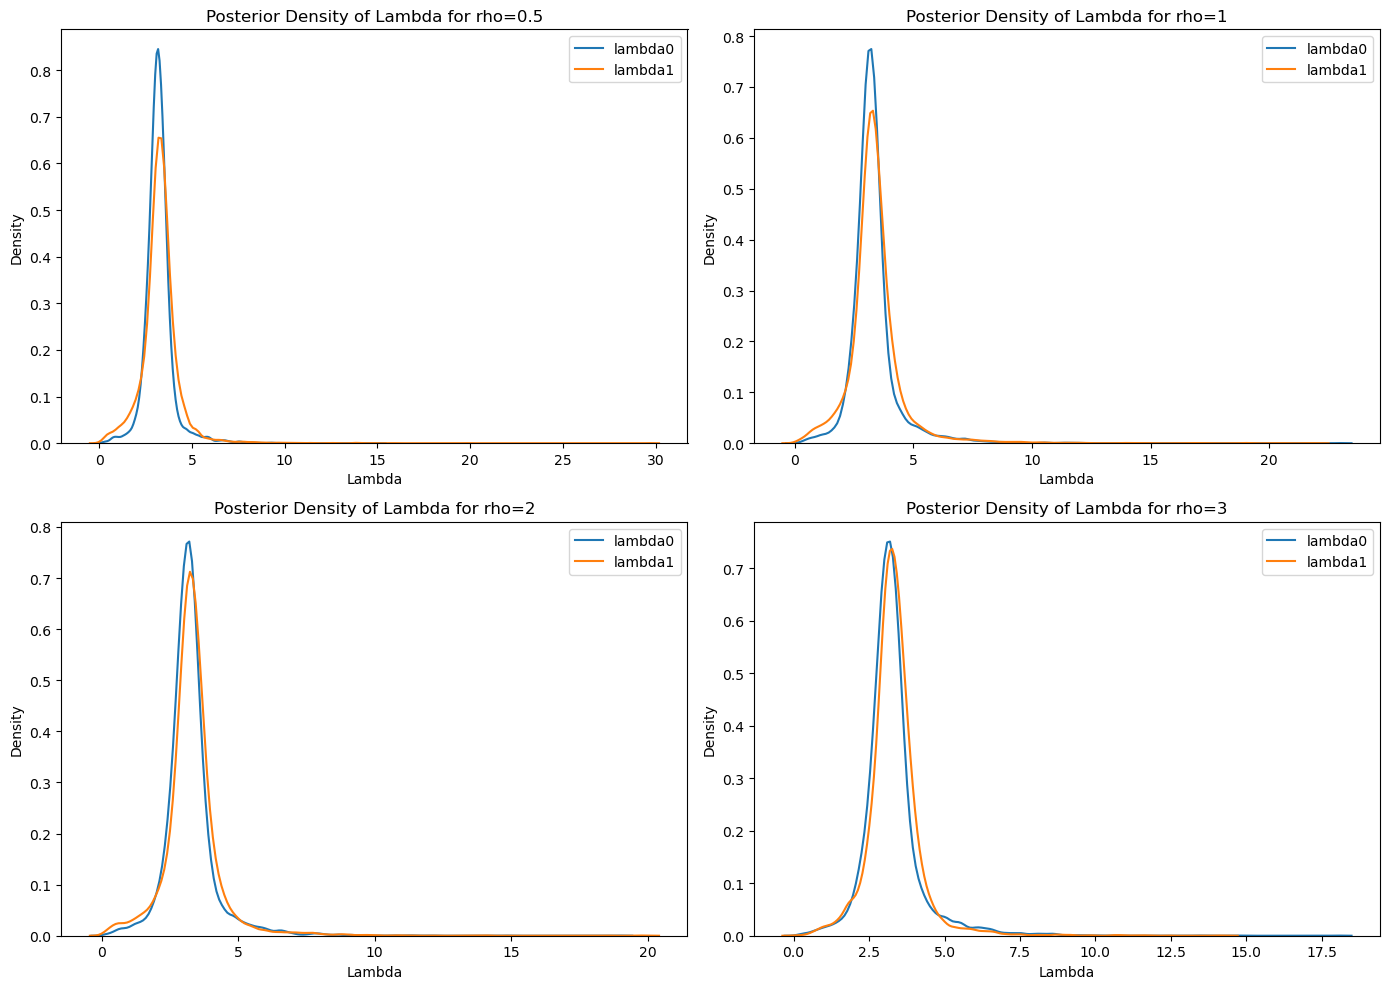

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 

for rho in range(4):
    ax = axes[rho]
    lambda_chain = np.array(values_rho[rho][0])[1000:] # after burn-in
    for i in range(lambda_chain.shape[1]):
        sns.kdeplot(lambda_chain[:, i], label=f"lambda{i}", fill=False, ax=ax, warn_singular=False)
    ax.set_title(f"Posterior Density of Lambda for rho={rho_vec[rho]}")
    ax.set_xlabel("Lambda")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

#### autocorr

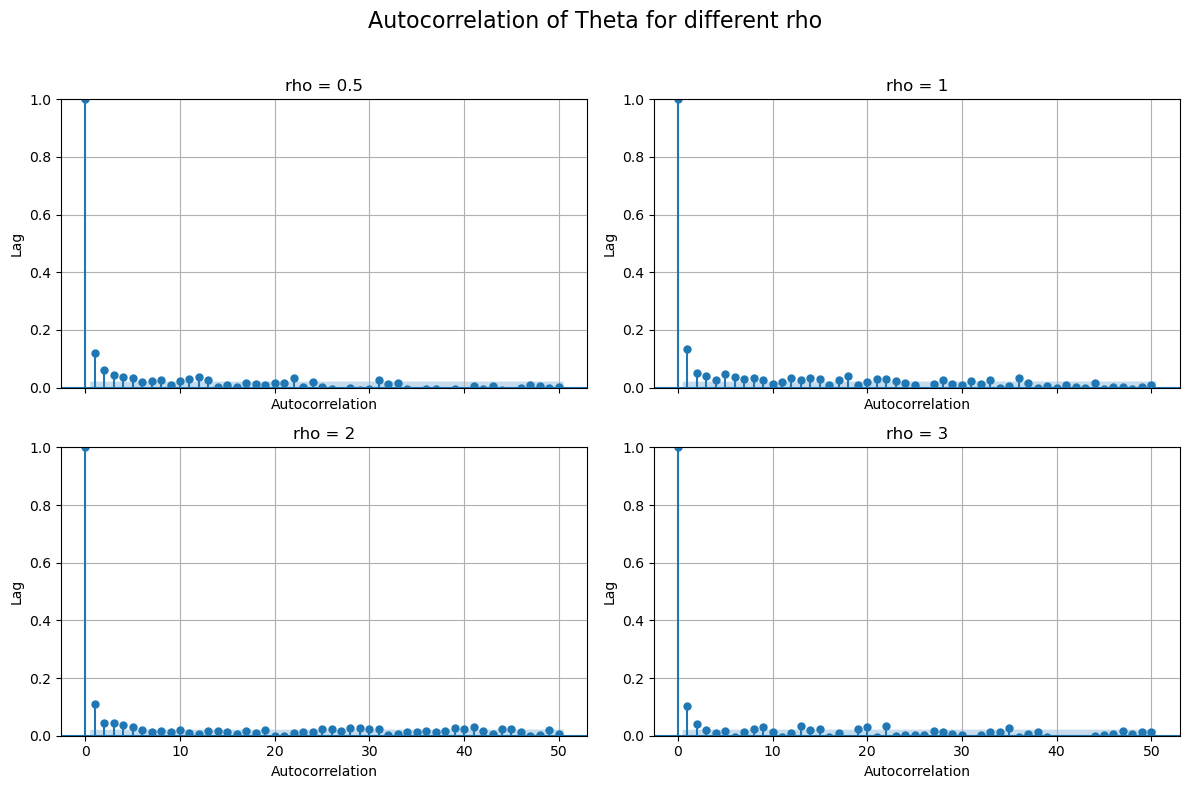

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for rho in range(4):
    theta_store = np.array(values_rho[rho][1])
    ax = axes[rho]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"rho = {rho_vec[rho]}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for different rho", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### mixing - not done yet!

In [31]:
# autocorrelation?